In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array


from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

colors = ['#F94144', '#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#90BE6D', '#43AA8B', '#4D908E', '#577590', '#277DA1']

cmap = ['#F94144', '#277DA1']

cmap_name = 'my colormap'

c_map = LinearSegmentedColormap.from_list(cmap_name, cmap)


# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

In [35]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TEST.ts')

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))
X_train = X_train.to_numpy()

## SOM for finding clusters

In [75]:
size_som = 30

som = MiniSom(size_som, size_som, X_train.shape[1], sigma=5, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)
som.pca_weights_init(X_train)
som.train(X_train, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.123020227105689


In [76]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

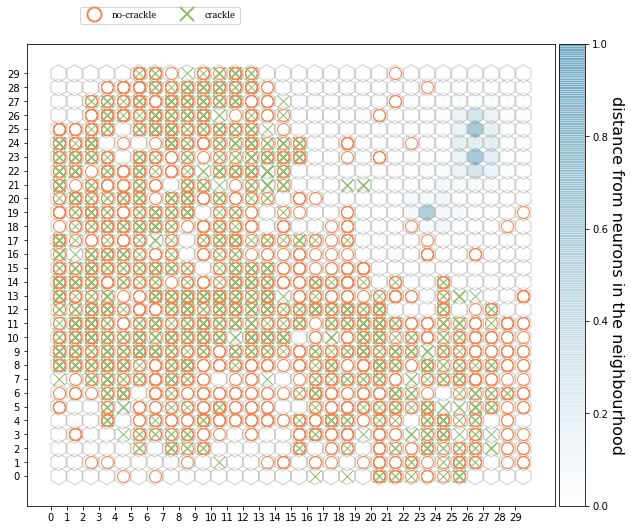

In [77]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=c_map(umatrix[i, j]), 
                             alpha=.4, 
        b                     edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', 'x']
label_colors  = [colors[3], colors[5]]
for cnt, x in enumerate(X_train):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * 2 / np.sqrt(3) * 3 / 4

    plt.plot(wx, wy, 
             markers[y_train[cnt]], 
             markerfacecolor='None',
             markeredgecolor=label_colors[y_train[cnt]], 
             markersize=12, 
             markeredgewidth=1)
    
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=c_map, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)
legend_elements = [Line2D([0], [0], marker='o', color=label_colors[0], label='no-crackle',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color=label_colors[1], label='crackle',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=2, prop = font)

#plt.savefig('resulting_images/som_seed_hex.png')
plt.show()

## SOM CLUSTERING

In [3]:
# Initialization and training
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(X_train, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 


 quantization error: 1.4368537579836778


In [36]:
isinstance(X_test, pd.DataFrame)

True

In [41]:
class SOM_clustering:
    def __init__(self, n_clusters = 3):
        self.clusters = n_clusters
    
    def fit(self, X_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        som_shape = (1, self.clusters)
        som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=.5, learning_rate=.5,
                      neighborhood_function='gaussian', random_seed=10)

        som.train_batch(X_train, 500, verbose=False)
        self.som = som
        
    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()
        winner_coordinates = np.array([self.som.winner(x) for x in X_test]).T
        return winner_coordinates[1]
        

In [12]:
X_test = X_test.to_numpy()

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X_test]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)


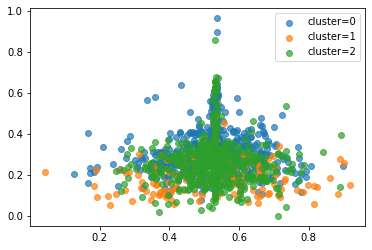

In [13]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(X_test[cluster_index == c, 0],
                X_test[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)


plt.legend();
